In [1]:
import torch
from torch import nn, optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from matplotlib.pylab import plt
from PIL import Image
import os
import numpy as np
from torchsummary import summary
from tqdm import trange
from copy import deepcopy
import torch.nn.functional as F

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
IMG_HEIGHT = 320
IMG_WIDTH = 400
N_CHANNELS = 3
EPOCHS = 20
BATCH_SIZE = 8

In [4]:
class MyDataSet(Dataset):
    def __init__(self, transform=None, target_transform=None, training=True):
        super().__init__()
        self.path = 'data/'
        self.mask_path = self.path + 'CameraMask/'
        self.rgd_path = self.path + 'CameraRGB/'
        self.mask_data = os.listdir(self.mask_path)
        self.rgb_data = os.listdir(self.rgd_path)
        
        self.len = len(self.mask_data)
        self.train_size = int(self.len * 0.9)

        self.transform = transform
        self.target_transform = target_transform

        if training:
            self.rgb_data = self.rgb_data[:self.train_size]
            self.mask_data = self.mask_data[:self.train_size]
            self.len = len(self.mask_data)
        else:
            self.rgb_data = self.rgb_data[self.train_size:]
            self.mask_data = self.mask_data[self.train_size:]
            self.len = len(self.mask_data)

    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
            
        x = Image.open(self.rgd_path + self.rgb_data[index]).convert('RGB')
        y = Image.open(self.mask_path + self.mask_data[index]).convert('RGB')

        if self.transform:
            x = self.transform(x)
        if self.target_transform:
            y = self.target_transform(y)
        return x, y

In [5]:
x_transform = transforms.Compose([transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
                                  transforms.ToTensor(),])

y_transform = transforms.Compose([transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
                                  transforms.ToTensor(), 
                                  transforms.Lambda(lambda y: (torch.max(y, dim=0, keepdim=False)[0]*255.).type(torch.LongTensor)),
                                  ])

train_data = MyDataSet(transform=x_transform, target_transform=y_transform, training=True)
val_data = MyDataSet(transform=x_transform, target_transform=y_transform, training=False)

print('training data:', len(train_data))
print('validation data:', len(val_data))

training data: 954
validation data: 106


In [6]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        if len(display_list[i].shape)==3:
            plt.imshow(np.asarray(display_list[i].cpu().permute(1, 2, 0).detach()))
        else:
            plt.imshow(np.asarray(display_list[i].cpu().squeeze(1).detach()))

        plt.axis('off')
    plt.show()

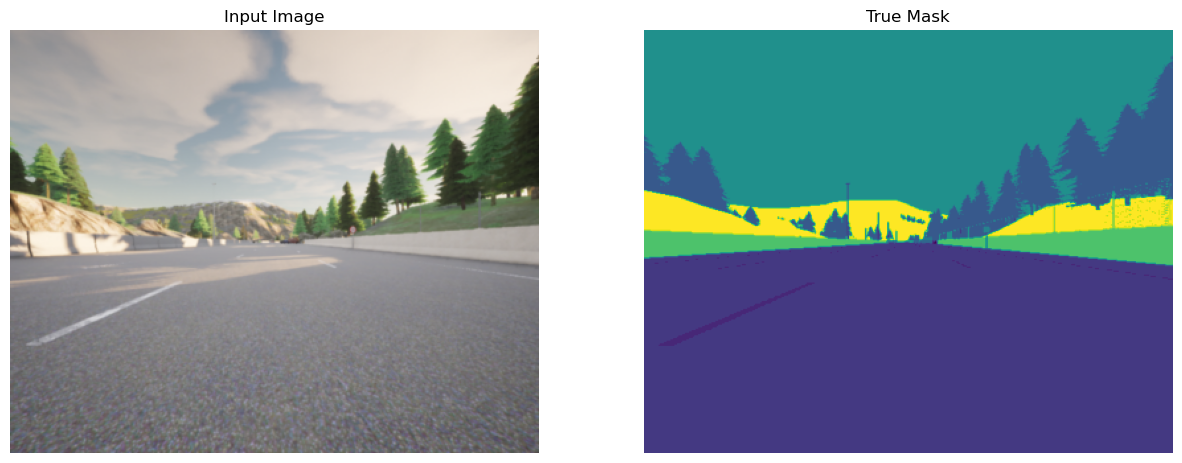

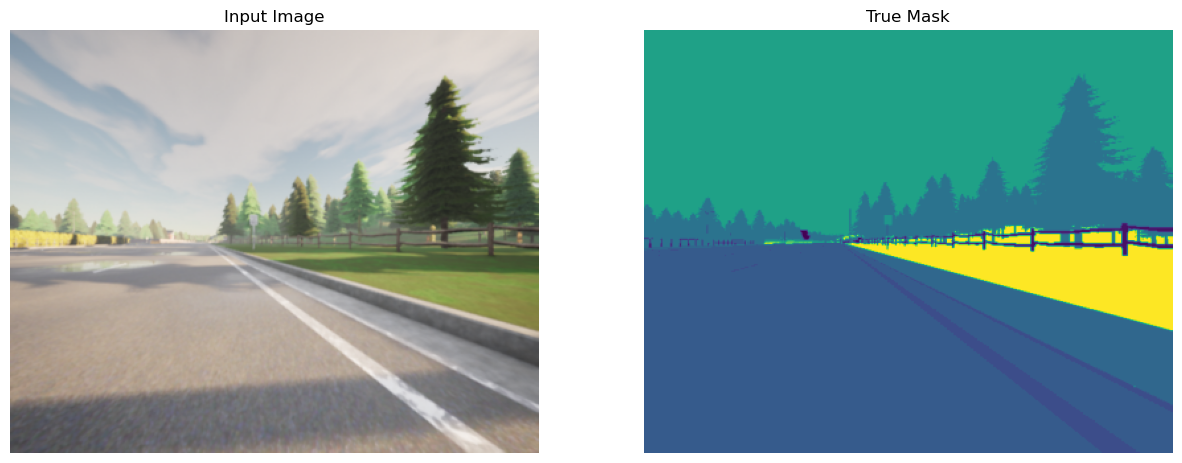

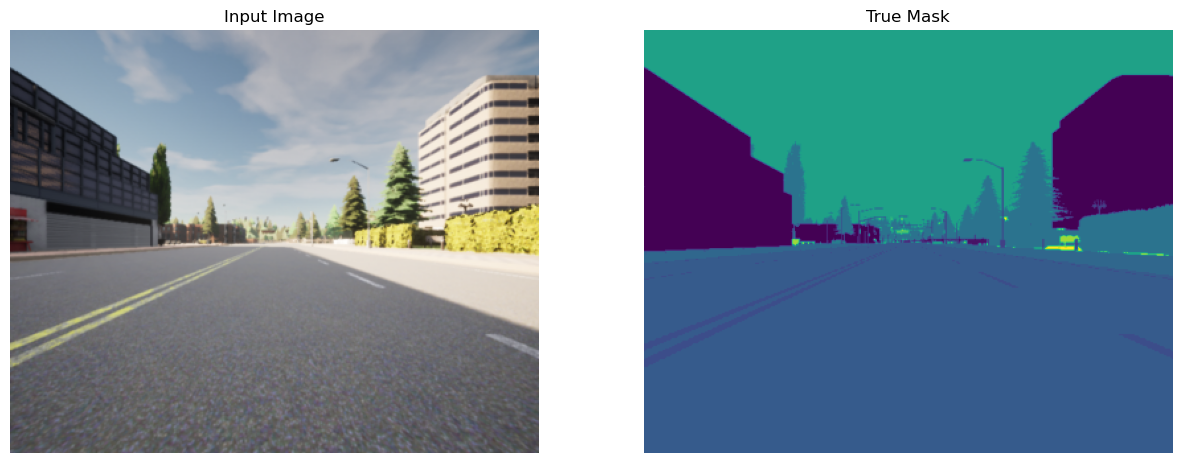

In [7]:
n = 2
for i, (image, mask) in enumerate(DataLoader(train_data, batch_size=None, shuffle=True)):
    display([image, mask])
    if i == n:
        break

In [8]:
class Conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_prob=0, maxpool_option=True):
        super().__init__()
        
        self.dropout_prob = dropout_prob
        self.maxpool_option = maxpool_option
        self.out_channels = out_channels

        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, 1, 1)
        nn.init.kaiming_normal_(self.conv1.weight, nonlinearity='relu')
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1)
        nn.init.kaiming_normal_(self.conv2.weight, nonlinearity='relu')
        
        self.dropout = nn.Dropout(dropout_prob)
        self.maxpool = nn.MaxPool2d(2)

    def forward(self, out):
        out = F.relu(self.conv1(out))
        out = F.relu(self.conv2(out))
        
        if self.dropout_prob > 0:
            out = self.dropout(out)

        if self.maxpool_option:
            next_layer = self.maxpool(out)
        else:
            next_layer = out

        skip_connection = out
        return next_layer, skip_connection

In [9]:
class Up_block(nn.Module):
    def __init__(self, in_channels, out_channels, contract_channel):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, out_channels, 3, 2, 1, 1)
        self.out_channels = self.up.out_channels + contract_channel

        self.concatenate = transforms.Lambda(lambda x: torch.cat(x, dim=1))

        self.conv1 = nn.Conv2d(self.out_channels, self.out_channels, 3, 1, 1)
        nn.init.kaiming_normal_(self.conv1.weight, nonlinearity='relu')

        self.conv2 = nn.Conv2d(self.out_channels, self.out_channels, 3, 1, 1)  
        nn.init.kaiming_normal_(self.conv2.weight, nonlinearity='relu')
    
    def forward(self, out, contract_input):
        out = self.up(out)
        out = self.concatenate([out, contract_input])
        out = F.relu(self.conv1(out))
        out = F.relu(self.conv2(out))
        return out

In [10]:
class Unet_model(nn.Module):
    def __init__(self, in_channels, out_channels, n_class=23):
        super().__init__()
        
        self.cblock1 = Conv_block(in_channels, out_channels)
        self.cblock2 = Conv_block(out_channels, out_channels * 2)
        self.cblock3 = Conv_block(out_channels * 2, out_channels * 4)
        self.cblock4 = Conv_block(out_channels * 4, out_channels * 8)
        self.cblock5 = Conv_block(out_channels * 8, out_channels * 16, dropout_prob=0.3, maxpool_option=False)

        self.ublock6 = Up_block(out_channels * 16, out_channels * 8, self.cblock4.out_channels)
        self.ublock7 = Up_block(self.ublock6.out_channels, out_channels * 4, self.cblock3.out_channels)
        self.ublock8 = Up_block(self.ublock7.out_channels, out_channels * 2, self.cblock2.out_channels)
        self.ublock9 = Up_block(self.ublock8.out_channels, out_channels, self.cblock1.out_channels)
        
        self.conv9 = nn.Conv2d(self.ublock9.out_channels, out_channels, 3, 1, 1)
        nn.init.kaiming_normal_(self.conv9.weight, nonlinearity='relu')
        self.conv10 = nn.Conv2d(out_channels, n_class, 1, 1)     
        nn.init.kaiming_normal_(self.conv10.weight, nonlinearity='relu')
   
    def forward(self, out):
        cblock1 = self.cblock1(out)
        cblock2 = self.cblock2(cblock1[0])
        cblock3 = self.cblock3(cblock2[0])
        cblock4 = self.cblock4(cblock3[0])
        cblock5 = self.cblock5(cblock4[0])

        ublock6 = self.ublock6(cblock5[0], cblock4[1])
        ublock7 = self.ublock7(ublock6, cblock3[1])
        ublock8 = self.ublock8(ublock7, cblock2[1])
        ublock9 = self.ublock9(ublock8, cblock1[1])

        conv9 = F.relu(self.conv9(ublock9))
        conv10 = self.conv10(conv9)
        return conv10


In [11]:
unet = Unet_model(3, 16).to(device)
summary(unet, input_size=(3, IMG_HEIGHT, IMG_WIDTH), batch_size=BATCH_SIZE, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [8, 16, 320, 400]             448
            Conv2d-2          [8, 16, 320, 400]           2,320
         MaxPool2d-3          [8, 16, 160, 200]               0
        Conv_block-4  [[-1, 16, 160, 200], [-1, 16, 320, 400]]               0
            Conv2d-5          [8, 32, 160, 200]           4,640
            Conv2d-6          [8, 32, 160, 200]           9,248
         MaxPool2d-7           [8, 32, 80, 100]               0
        Conv_block-8  [[-1, 32, 80, 100], [-1, 32, 160, 200]]               0
            Conv2d-9           [8, 64, 80, 100]          18,496
           Conv2d-10           [8, 64, 80, 100]          36,928
        MaxPool2d-11            [8, 64, 40, 50]               0
       Conv_block-12  [[-1, 64, 40, 50], [-1, 64, 80, 100]]               0
           Conv2d-13           [8, 128, 40, 50]          73,85

In [12]:
def train_model(model, criterion, optimizer, train, val, device, batch_size=32, epochs=10, patience_threshold=None, scheduler=None):
    """This function will train model and return history, best, latest model"""
    trainloader = DataLoader(dataset=train, batch_size=batch_size, shuffle=True)
    valloader = DataLoader(dataset=val, batch_size=batch_size, shuffle=True)
    batches_per_epoch = len(trainloader)
    patience = 0

    latest = {'model': None, 'acc': 0, 'loss': 10e3, 'optimizer': None}
    best = {'model': None, 'acc': 0, 'loss': 10e3, 'optimizer': None}
    history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}
    for epoch in range(epochs):
        with trange(batches_per_epoch, unit='batch') as pbar:
            pbar.set_description(f'{epoch + 1} epoch(s)')

            # train mode
            train_loss = 0
            train_acc = 0
            model.train()
            for x, y in trainloader:
                optimizer.zero_grad()                
                x, y = x.to(device), y.to(device)
                
                yhat = model(x)
                _, label = torch.max(yhat, dim=1)

                loss = criterion(yhat, y)
                loss.backward()
                optimizer.step()
                train_loss += loss.item()
                train_acc += (label==y).sum().item()
                pbar.update()
                pbar.set_postfix_str(f'train_loss: {loss.item():.4f}')


            train_loss = round(train_loss/len(trainloader), 4)
            train_acc = round(train_acc/(len(train) * IMG_HEIGHT * IMG_WIDTH), 3)

            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)

            # eval mode
            val_loss = 0
            val_acc = 0
            model.eval()
            for x, y in valloader:
                x, y = x.to(device), y.to(device)
                yhat = model(x)
                _, label = torch.max(yhat, dim=1)

                val_loss += criterion(yhat, y).item()
                val_acc += (label==y).sum().item()

            val_loss = round(val_loss/len(valloader), 4)
            val_acc = round(val_acc/(len(val) * IMG_HEIGHT * IMG_WIDTH), 3)
            
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)

            
            # update learning rate
            if scheduler:
                pbar.set_postfix_str(f'train_loss: {train_loss} train_acc: {train_acc} val_loss: {val_loss} val_acc: {val_acc} learning_rate: {scheduler.get_last_lr()[0]:.0e}')
                scheduler.step()
            else:
                pbar.set_postfix_str(f'train_loss: {train_loss} train_acc: {train_acc} val_loss: {val_loss} val_acc: {val_acc}')

            # best model and early stop
            if val_loss < best['loss']:
                best['model'] = deepcopy(model)
                best['acc'] = deepcopy(val_acc)
                best['loss'] = deepcopy(val_loss)
                best['optimizer'] = deepcopy(optimizer)
                patience = 0


            latest['model'] = deepcopy(model)
            latest['acc'] = deepcopy(val_acc)
            latest['loss'] = deepcopy(val_loss)
            latest['optimizer'] = deepcopy(optimizer)
            
            if patience_threshold:
                patience += 1
                if patience == patience_threshold:
                    break

    return history, best, latest

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=[params for params in unet.parameters() if params.requires_grad==True], lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=12, gamma=0.1)

In [14]:
history, best, latest = train_model(model=unet, criterion=criterion, optimizer=optimizer,
                                    train=train_data, val=val_data, device=device,
                                    batch_size=BATCH_SIZE, epochs=EPOCHS, scheduler=scheduler)

20 epoch(s): 100%|██████████| 120/120 [01:03<00:00,  1.90batch/s, train_loss: 0.2388 train_acc: 0.939 val_loss: 0.4453 val_acc: 0.891 learning_rate: 1e-04]


In [15]:
def plot_history(history):
    "This function wil plot history of loss and acc according to epochs"
    plt.figure(figsize=(20, 10)) 
    plt.tight_layout()

    plt.subplot(1, 2, 1); plt.plot(history['train_loss'], label='loss')
    plt.plot(history['val_loss'], label='val_loss'); plt.legend()

    plt.subplot(1, 2, 2); plt.plot(history['train_acc'], label='accuracy')
    plt.plot(history['val_acc'], label='val_accuracy'); plt.legend()

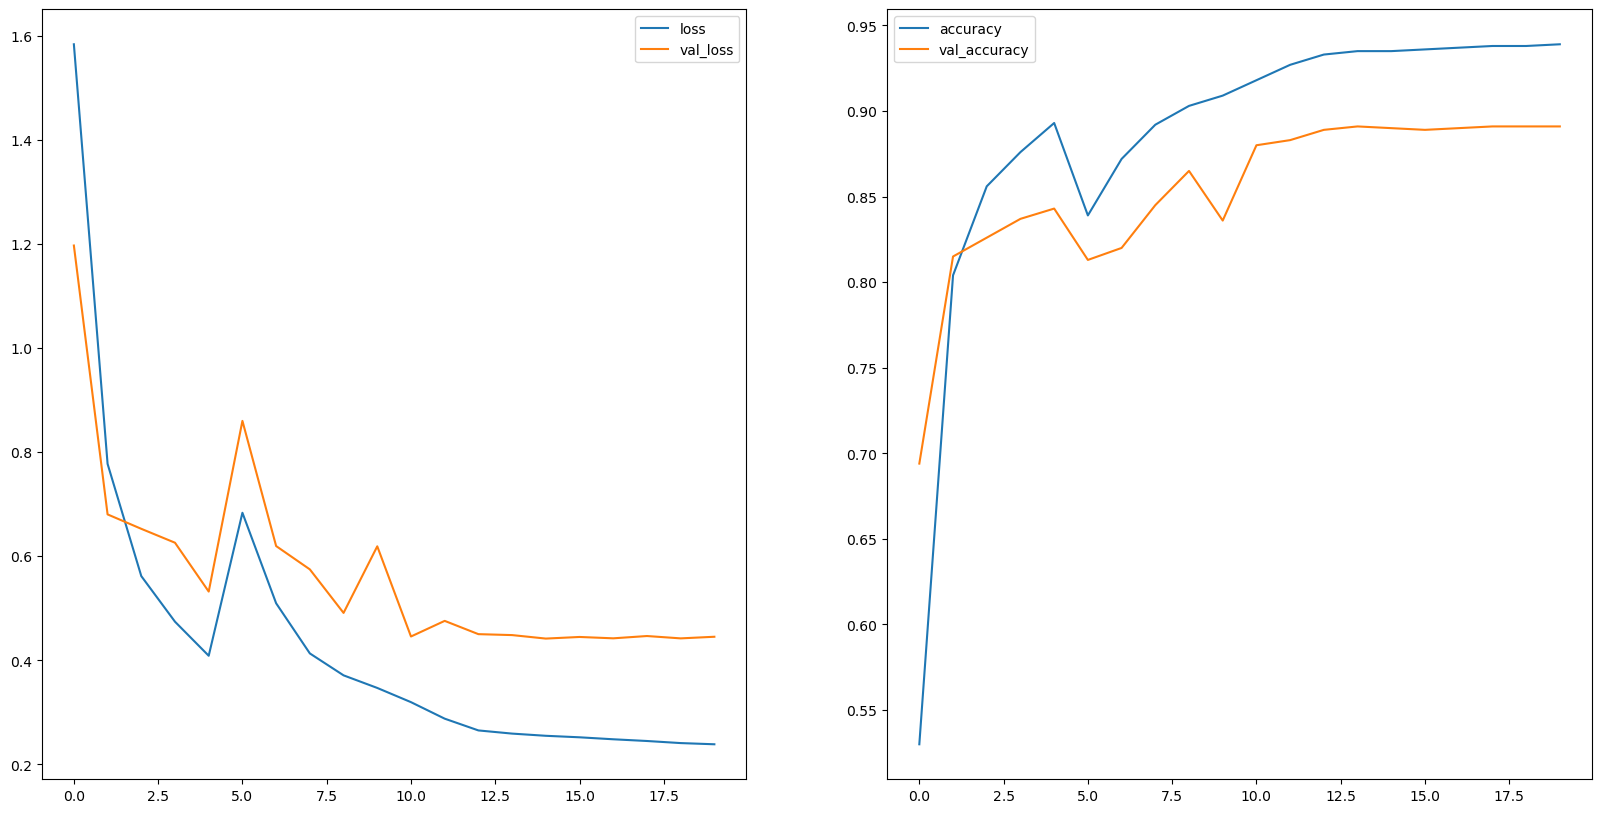

In [16]:
plot_history(history)

In [17]:
model_best = best['model']
optimizer_best = best['optimizer']
model_lastest = latest['model']
optimizer_latest = latest['optimizer']

torch.save({
            'model_best': model_best.state_dict(),
            'optimizer_best': optimizer_best.state_dict(),
            'model_latest': model_lastest.state_dict(),
            'optimizer_latest':optimizer_latest.state_dict()
            },'unet.pt')

In [18]:
def predictions(model, image):
        model.eval()
        pred_mask = model(image.unsqueeze(0))
        pred_mask = torch.argmax(pred_mask, axis=1)
        pred_mask = pred_mask
        return pred_mask

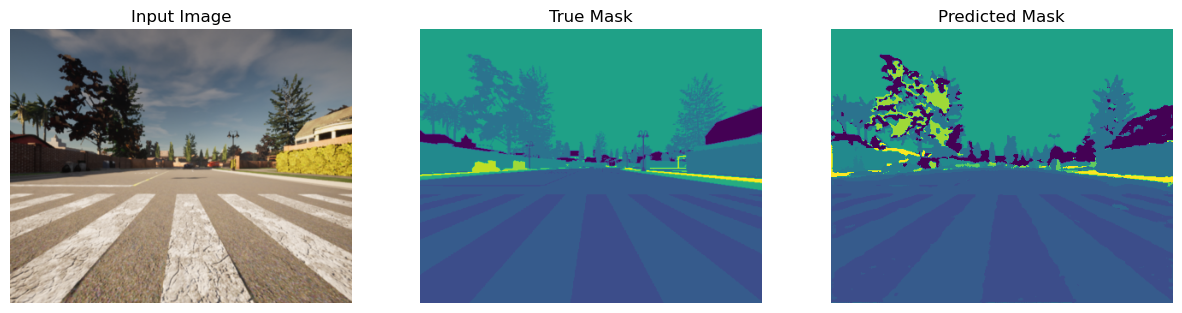

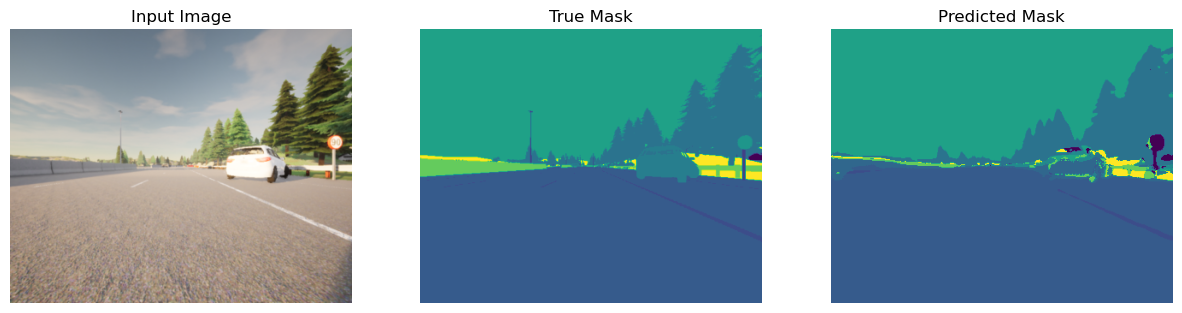

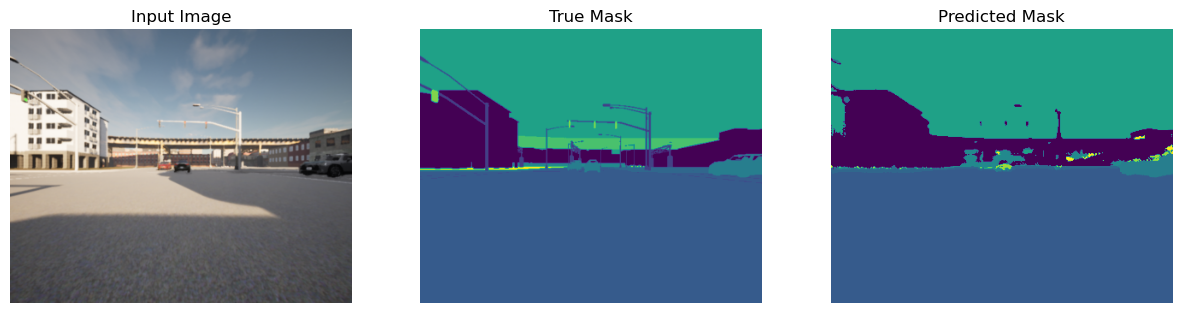

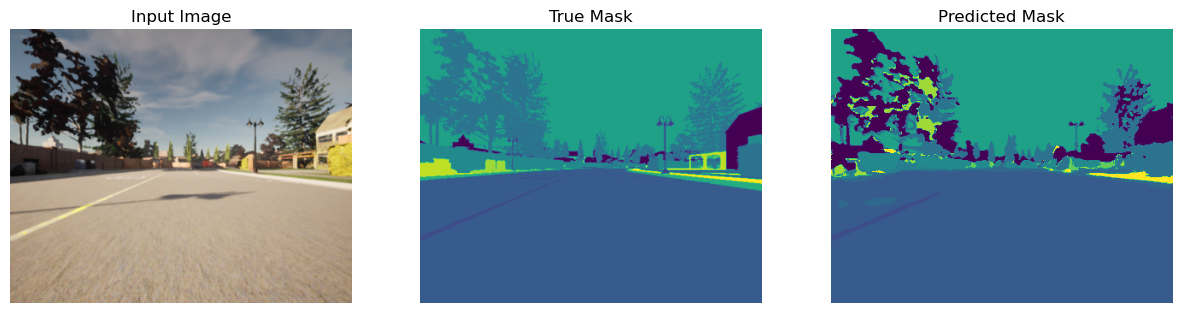

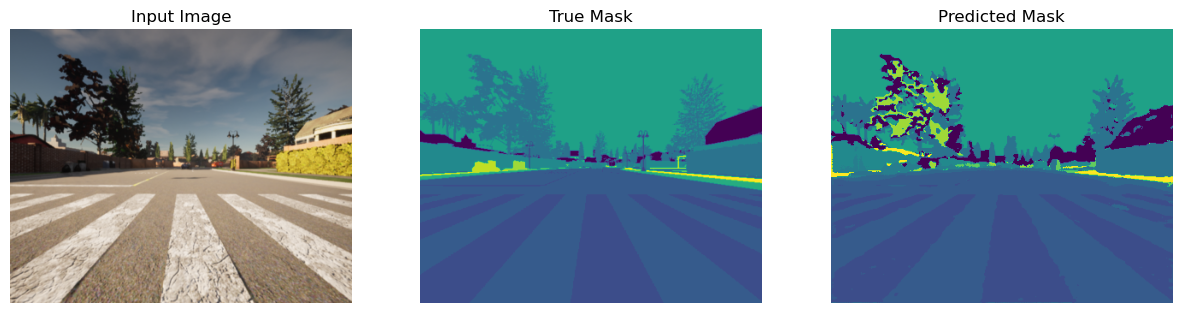

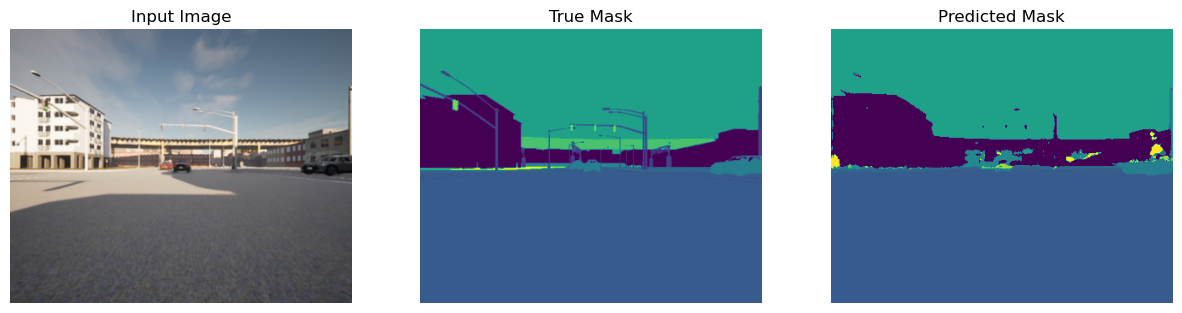

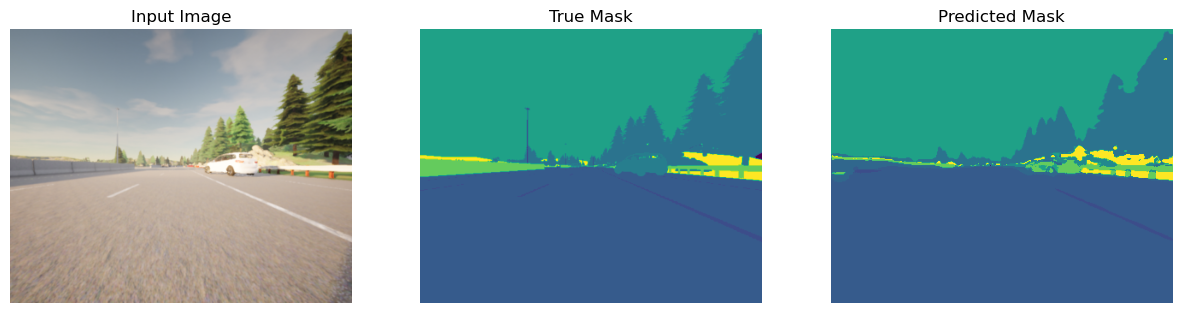

In [23]:
best_model = Unet_model(3, 16).to(device)
best_model.load_state_dict(torch.load('unet.pt', map_location=device)['model_best'])
best_model.to(device)

n = 6
for i, (x, y) in enumerate(DataLoader(val_data, batch_size=None, shuffle=True)):
    x, y = x.to(device), y.to(device)
    display([x, y, predictions(best_model, x)])
    if i == 6:
        break